In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import torch.utils.data as Data
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pyplot as plt
import scipy

In [2]:
# ### find bugs if cuda didn't tell us where the bugs were
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(input_size+1000, hidden_size)
        self.position_encoding = nn.Embedding(input_size+1000, hidden_size)
        
        self.transformer = nn.Transformer(d_model=hidden_size, nhead=num_heads, num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, dim_feedforward=hidden_size, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, src, tgt):
        src_embedded = self.embedding(src.long()) + self.position_encoding(src.long())
        tgt_embedded = self.embedding(tgt.long()) + self.position_encoding(tgt.long())
        
        src_embedded = src_embedded.permute(1, 0, 2)  # Shape: (src_len, batch_size, hidden_size)
        tgt_embedded = tgt_embedded.permute(1, 0, 2)  # Shape: (tgt_len, batch_size, hidden_size)
        
        output = self.transformer(src_embedded, tgt_embedded)
        
        output = output.permute(1, 0, 2)  # Shape: (batch_size, tgt_len, hidden_size)
        output = self.fc(torch.tanh(output))
        
        return output


In [4]:
train = np.load("./data_nature/down_cell_data.npy")
train = train[:2000,:]
label = np.load("./data_nature/label_chirp.npy")
label = label.T[:2000,:]

X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=50)

X_train_final = torch.from_numpy(X_train.astype(np.float32))
y_train_final = torch.from_numpy(y_train.astype(np.float32))
X_test_final = torch.from_numpy(X_test.astype(np.float32))
y_test_final = torch.from_numpy(y_test.astype(np.float32))

train_data = Data.TensorDataset(X_train_final, y_train_final)
test_data = Data.TensorDataset(X_test_final, y_test_final)
train_loader = Data.DataLoader(dataset=train_data, batch_size=4,
                               shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset=test_data, batch_size=16,
                               shuffle=True, num_workers=0)

In [5]:
input_dim = 1503 
output_dim = 249  
# seq_length = 1503 
hidden_dim = 512
num_layers = 10
num_heads = 8  
# max_seq_length = seq_length
dropout = 0.5

model_test = TransformerModel(input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout)
device = torch.device(("cuda" if torch.cuda.is_available() else "cpu"))
### use multi-GPU training
model_test.to(device)
optimizer = torch.optim.Adam(model_test.parameters(), lr=0.01)
criterion = nn.MSELoss() # add L2-regularization

train_losses = []
num_epochs = 100

In [6]:
for epoch in range(num_epochs):
    model_test.train()
    epoch_loss = 0.0
    train_total_out = []
    
    for step, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model_test(inputs, inputs)
        # print("a:", output[:,0,:].size(), "b:", targets.size())
        # print("out:", output[:,0,:], "target:", targets)
        loss = criterion(output[:,0,:], targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        train_total_out.append(output)
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    

RuntimeError: CUDA out of memory. Tried to allocate 314.00 MiB (GPU 0; 31.75 GiB total capacity; 4.65 GiB already allocated; 238.50 MiB free; 4.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
train_final_out = torch.cat(train_total_out)
train_final_out[:,0,:].size()

torch.Size([700, 249])

In [15]:
y_train_trans = train_final_out[:,0,:].cpu().data.numpy()
scipy.io.savemat('./data_nature/official_transformer_train_1000epc.mat', {'official_transformer_train_1000epc':y_train_trans.T})
scipy.io.savemat('./data_nature/train_official_transformer_1000epc.mat', {'train_official_transformer_1000epc':y_train.T})

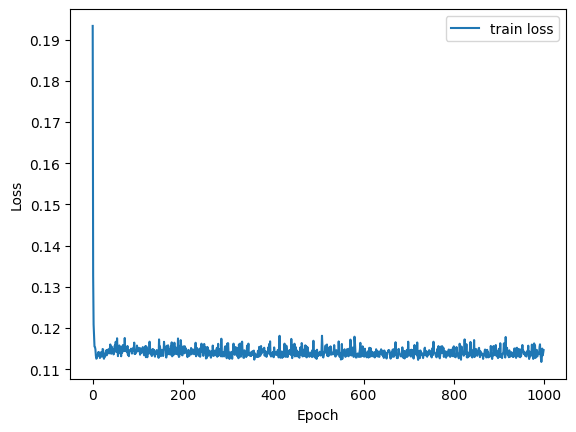

In [16]:
### Plot the loss
plt.plot(train_losses, label='train loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
model_test.eval()
test_loss = 0.0
total_out = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        outputs = model_test(inputs.to(device), inputs.to(device))
        # print(outputs.size(), targets.size())
        loss = criterion(outputs[:,0,:], targets.to(device))
        test_loss += loss.item() * len(inputs)
        total_out.append(outputs)
        
test_loss /= len(test_data)

In [18]:
final_out = torch.cat(total_out)
final_out[:,0,:].size()
y_pre_trans = final_out[:,0,:].cpu().data.numpy()
scipy.io.savemat('./data_nature/official_transformer_test_1000epc.mat', {'official_transformer_test_1000epc':y_pre_trans.T})
scipy.io.savemat('./data_nature/test_official_transformer_1000epc.mat', {'test_official_transformer_1000epc':y_test.T})